<a href="https://colab.research.google.com/github/YS-JEOUNG/amazon-review-project/blob/main/code/artscrafts_wordvec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/arts_total_cleaned.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130133 entries, 0 to 130132
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   overall           130133 non-null  float64
 1   vote              130133 non-null  int64  
 2   verified          130133 non-null  bool   
 3   reviewer_id       130133 non-null  object 
 4   asin              130133 non-null  object 
 5   style             130133 non-null  object 
 6   reviewer_name     130128 non-null  object 
 7   unix_review_time  130133 non-null  int64  
 8   category          130133 non-null  object 
 9   description       130133 non-null  object 
 10  title             130133 non-null  object 
 11  brand             129770 non-null  object 
 12  rank              130133 non-null  object 
 13  main_cat          129791 non-null  object 
 14  date              20908 non-null   object 
 15  price             115105 non-null  object 
 16  review_text       13

In [ ]:
df['rating_class'] = df['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
X = df['clean_text']
y = df['rating_class']

# Tokenizer

In [ ]:
samples = X
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 71148 unique tokens.


In [ ]:
sequences[0]

[30,
 44,
 1933,
 191,
 189,
 56,
 533,
 1096,
 343,
 6086,
 1933,
 223,
 8,
 8,
 3219,
 15850,
 343,
 60,
 3177,
 2855,
 129,
 301,
 930,
 151,
 8]

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in sequences[0]])

In [ ]:
def sequence_to_text(sequence):
    words = [reverse_word_index.get(letter) for letter in sequence]
    return words

In [ ]:
my_text = list(map(sequence_to_text, sequences))

In [ ]:
sequences[0]

[30,
 44,
 1933,
 191,
 189,
 56,
 533,
 1096,
 343,
 6086,
 1933,
 223,
 8,
 8,
 3219,
 15850,
 343,
 60,
 3177,
 2855,
 129,
 301,
 930,
 151,
 8]

# Word2Vec and Simple Neural Network

In [ ]:
word2vec = gensim.models.Word2Vec(my_text, size=100, window=10, min_count=1)

In [ ]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# word2vec에서 total_examples 혹은 total_words 파라미터를 필수로 줘야 하는데
# 그 개수가 뭔지 몰라서 total_words(raw tokens) 개수 찾기
raw_tokens = len([w for t in (df['clean_text'].apply(word_tokenize)) for w in t])
print(f'number of raw tokens: {raw_tokens}')

number of raw tokens: 5260371


In [ ]:
# 같은 방법으로 문장개수(total_examples) 찾아보기
raw_sent = len([w for t in (df['clean_text'].apply(sent_tokenize)) for w in t])
print(f'number of raw sent: {raw_sent}')

number of raw sent: 130133


In [ ]:
word2vec.train(my_text, total_examples=130133, epochs=10)

(46504884, 52607720)

In [ ]:
# 예시 단어들은 이전에 wordcloud에서 본 긍정리뷰와 부정리뷰 단어들 좀더 뽑아서 해도 될 듯. 분야마다 쓰이는 단어가 다르니까.
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                 for search_term in ['feel', 'good', 'product', 'cheap', 'junk', 'bad', 'great', 'price', 'love']}
similar_words

{'bad': ['terrible', 'good', 'unlucky', 'ok', 'poor'],
 'cheap': ['flimsy', 'cheep', 'cheaply', 'crappy', 'cheapo'],
 'feel': ['texture', 'scratchy', 'felt', 'slippery', 'clearlays'],
 'good': ['great', 'decent', 'nice', 'excellent', 'bad'],
 'great': ['good', 'excellent', 'fantastic', 'awesome', 'wonderful'],
 'junk': ['crap', 'garbage', 'worthless', 'utter', 'rubbish'],
 'love': ['awesome', 'wonderful', 'adore', 'amaze', 'favorite'],
 'price': ['cost', 'prise', 'sale', 'pricey', 'expensive'],
 'product': ['itehem', 'products', 'seller', 'vendor', 'turnaroundtime']}

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=10_000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

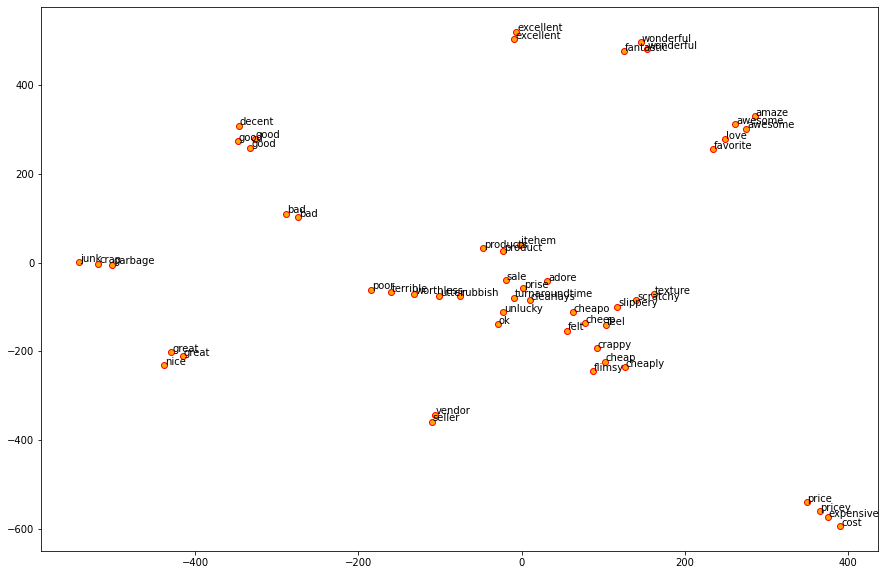

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
len(word_index.keys())

71148

In [ ]:
len(word2vec.wv.vocab)

71148

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
max_length = 200
max_words = len(word_index.keys())

# 원본에는 6000, 2933이라고 나와있는데 어디서 나온 숫자????
# 내맘대로 6000과 3000으로 해보겠음.
training_samples = 6000
validation_samples = 3000
data = pad_sequences(sequences, maxlen=max_length)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (130133, 200)
Shape of label tensor: (130133,)


In [ ]:
# shuffle and split the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

x_train = data[:training_samples]
y_train = y[:training_samples]
x_val = data[training_samples: training_samples+validation_samples]
y_val = y[training_samples: training_samples+validation_samples]

print('shape of training data:', x_train.shape)
print('shape of validation data:', x_val.shape)

shape of training data: (6000, 200)
shape of validation data: (3000, 200)


In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word2vec.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(71149, 100)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [ ]:
model = Sequential()
model.add(Embedding(max_words+1, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          7114900   
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                640032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,754,965
Trainable params: 7,754,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10,
                    batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
188/188 [==============================] - 3s 11ms/step - loss: 0.6333 - acc: 0.7183 - val_loss: 0.5433 - val_acc: 0.7940
Epoch 2/10
188/188 [==============================] - 2s 10ms/step - loss: 0.3884 - acc: 0.8096 - val_loss: 0.6202 - val_acc: 0.7597
Epoch 3/10
188/188 [==============================] - 2s 10ms/step - loss: 0.2261 - acc: 0.9035 - val_loss: 0.8003 - val_acc: 0.7333
Epoch 4/10
188/188 [==============================] - 2s 10ms/step - loss: 0.1209 - acc: 0.9552 - val_loss: 1.0265 - val_acc: 0.7060
Epoch 5/10
188/188 [==============================] - 2s 10ms/step - loss: 0.0574 - acc: 0.9814 - val_loss: 1.3360 - val_acc: 0.7107
Epoch 6/10
188/188 [==============================] - 2s 10ms/step - loss: 0.0269 - acc: 0.9930 - val_loss: 1.7386 - val_acc: 0.7123
Epoch 7/10
188/188 [==============================] - 2s 10ms/step - loss: 0.0125 - acc: 0.9960 - val_loss: 2.0543 - val_acc: 0.7070
Epoch 8/10
188/188 [==============================] - 2s 11ms/step - 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

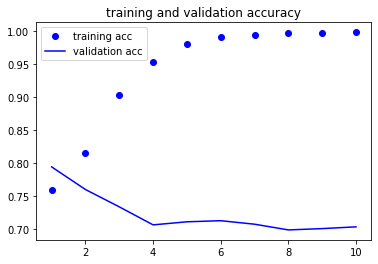

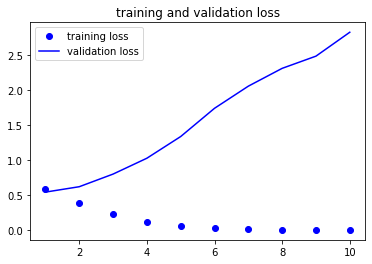

In [ ]:
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()